In [1]:
import numpy as np
import torch
from scipy import optimize
from sim.cartpole_dc import CartPoleEnv
import csv
from pyswarms.single.global_best import GlobalBestPSO
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import tikzplotlib
from util.io import read_data

In [3]:
states, actions = read_data('data.csv')
states = torch.tensor(states).detach()
actions = torch.tensor([actions]).T.detach()
print(states.shape, actions.shape)

torch.Size([24570, 4]) torch.Size([24570, 1])


In [40]:
def fun(theta, render=False, steps=20):
    env = CartPoleEnv(swingup=True, solver='rk')
    env.mu_cart = theta[0]
    env.Psi = theta[1]
    env.L = theta[2]
    env.J = theta[3]
    env.reset()
    env.state = states[:len(states)-steps]
    env.i = torch.zeros(len(states)-steps)
    for j in range(steps-1):
        env.step(actions[j:len(states)-(steps-j)])
    s, *_ = env.step(actions[steps-1:len(states)-1])
    s = s.numpy()
    env.close()
    return s

In [42]:
def loss_(theta):
    s = fun(theta)
    if (s != s).any():
        print('nan')
        return [np.inf]
    delta_phi = (states[20:,2] - s[:,2]) % (2 * np.pi)
    delta_phi = np.minimum(delta_phi, 2*np.pi - delta_phi)**2
    return (0.0 * delta_phi + (states[20:,0] - s[:,0])**2).numpy()

def loss(theta):
    losses = []
    for t in theta:
        losses += [np.sum(loss_(t))]
    return losses


In [ ]:
bounds = ([0.0001, 0.5, 0.01, 0.01], 
          [0.05, 3.0, 0.5, 0.5])
#pos = [0.04, 5, 1.5, 0.02]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
init_pos = None #np.clip(np.random.normal(pos, scale=0.2, size=(50, 4)), bounds[0], bounds[1])
optimizer = GlobalBestPSO(n_particles=50, dimensions=4, options=options, bounds=bounds, init_pos=init_pos)
cost, pos = optimizer.optimize(loss, 100)

2020-04-20 20:00:16,054 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}








pyswarms.single.global_best:   0%|          |0/100

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   0%|          |0/100, best_cost=85.3







pyswarms.single.global_best:   1%|          |1/100, best_cost=85.3

nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   1%|          |1/100, best_cost=85.3







pyswarms.single.global_best:   2%|▏         |2/100, best_cost=85.3

nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   2%|▏         |2/100, best_cost=59.1







pyswarms.single.global_best:   3%|▎         |3/100, best_cost=59.1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   3%|▎         |3/100, best_cost=59.1







pyswarms.single.global_best:   4%|▍         |4/100, best_cost=59.1

nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   4%|▍         |4/100, best_cost=59.1







pyswarms.single.global_best:   5%|▌         |5/100, best_cost=59.1

nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   5%|▌         |5/100, best_cost=59.1







pyswarms.single.global_best:   6%|▌         |6/100, best_cost=59.1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   6%|▌         |6/100, best_cost=59.1







pyswarms.single.global_best:   7%|▋         |7/100, best_cost=59.1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   7%|▋         |7/100, best_cost=56.5







pyswarms.single.global_best:   8%|▊         |8/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   8%|▊         |8/100, best_cost=56.5







pyswarms.single.global_best:   9%|▉         |9/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:   9%|▉         |9/100, best_cost=56.5







pyswarms.single.global_best:  10%|█         |10/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  10%|█         |10/100, best_cost=56.5







pyswarms.single.global_best:  11%|█         |11/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  11%|█         |11/100, best_cost=56.5







pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=56.5







pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=56.5

nan
nan
nan
nan










pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=56.5







pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=56.5

nan
nan
nan
nan










pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=56.5







pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=56.5







pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=56.5







pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=56.5







pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=56.5

nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=47.4







pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=47.4

nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=47.4







pyswarms.single.global_best:  20%|██        |20/100, best_cost=47.4

nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  20%|██        |20/100, best_cost=42.1







pyswarms.single.global_best:  21%|██        |21/100, best_cost=42.1

nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  21%|██        |21/100, best_cost=42.1







pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=42.1

nan
nan










pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=42.1







pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=42.1

nan
nan
nan










pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=42.1







pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=42.1

nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=42.1







pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=42.1

nan
nan
nan
nan










pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=42.1







pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=42.1

nan
nan
nan
nan
nan










pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=42.1







pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=42.1

nan
nan
nan
nan
nan










pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=42.1







pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=42.1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=42.1







pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=42.1

nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=42.1







pyswarms.single.global_best:  30%|███       |30/100, best_cost=42.1

nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  30%|███       |30/100, best_cost=42.1







pyswarms.single.global_best:  31%|███       |31/100, best_cost=42.1

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan










pyswarms.single.global_best:  31%|███       |31/100, best_cost=42.1







pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=42.1

nan
nan
nan
nan
nan










pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=42.1







pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=42.1

nan
nan
nan
nan
nan


[0.03690116 2.8391695  0.09165955 0.2180804 ]


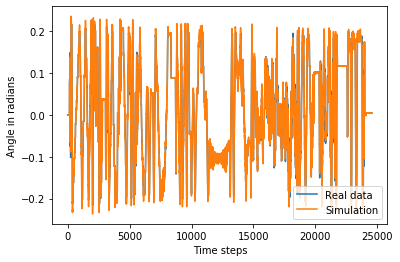

/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


1.7764459


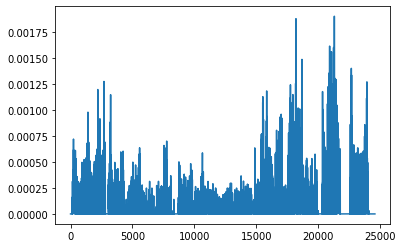

In [29]:
print(pos)
s = fun(pos)

plt.figure()
a, = plt.plot(states[:,0], label='Real data')
b, = plt.plot(s[:,0], label='Simulation')
plt.xlabel('Time steps')
plt.ylabel('Angle in radians')
plt.legend(handles=[a,b])
tikzplotlib.save("polefit.tex")
plt.show()

plt.figure()
plt.plot(loss_(pos))
print(np.sum(loss_(pos)))

In [49]:
optimize.least_squares(loss_, pos, bounds=bounds)

 active_mask: array([0, 0, 0, 0, 0])
        cost: 0.011053385213017464
         fun: array([2.2737371e-14, 2.2737371e-14, 2.2737371e-14, ..., 3.8595318e-09,
       3.8595318e-09, 3.8595318e-09], dtype=float32)
        grad: array([-0.00391693,  0.        ,  0.02159393,  0.01855953, -0.01856432])
         jac: array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 19
        njev: 8
  optimality: 0.030112236070514414
      status: 3
     success: True
           x: array([2.26273920e-01, 7.77691616e-01, 1.40447706e+00, 1.35050072e-03,
       1.65104690e-02])